In [2]:
%tensorflow_version 1.x

_git_branch = 'trainset'

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


# Import code from gitHub

In [3]:
import json
import subprocess
import sys
import time

import numpy as np
from IPython.core.display import display, HTML
from google.colab import files

!pip install overrides pyjarowinkler hdbscan


!rm -r nlp_tools
!git clone --single-branch --branch $_git_branch https://github.com/nemoware/analyser.git nlp_tools
 

sys.path.insert(0, '/content/nlp_tools')

 
import nltk
nltk.download('punkt')

     |████████████████████████████████| 4.7MB 30kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2361247 sha256=713baca5356ea36430612bbbb593d8818f70939ef6311744cc6d80ee701a275c
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
  Created wheel for overrides: filename=overrides-2.8.0-cp36-none-any.whl size=5609 sha256=4b083b532fd8cacbc9565556b2186bfb1e506a8df0af22233e1ef22e897ad6d1
  Stored in directory: /root/.cache/pip/wheels/df/f1/ba/eaf6cd7d284d2f257dc71436ce72d25fd3be5a5813a37794ab
Successfully built overrides
rm: cannot remove 'nlp_tools': No such file or directory
Cloning into 'nlp_tools'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (70/70), done.
remote: T

True

In [0]:
sys.path.insert(0, '/content/nlp_tools')

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_emb(matrix):
    
  mt = matrix.T
  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 6))
    ax = sns.heatmap(mt, square=False,  cmap="RdYlBu", center=0)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Prepare trainset


#### Mount drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Read meta

In [7]:
import pandas as pd
from os import path

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager

TRAINSETS_PATH='/content/drive/My Drive/GazpromOil/trainsets'
VERSION_PATH='1_1_19'
TRAINSET_META_FN='contracts.subjects-manually-filtered.csv'

csv_path = path.join(TRAINSETS_PATH, 'meta_info', TRAINSET_META_FN)

# trainset_meta = pd.read_csv(csv_path, encoding='utf-8' )
# trainset_rows = trainset_meta[trainset_meta['valid']]

dataset_manager = SubjectTrainsetManager(csv_path)

# print(dataset_manager.trainset_rows.info())
# trainset_rows.head()

Nemoware Analyser v1.6.11


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
loading word cases stats model /content/nlp_tools/analyser/vocab/word_cases_stats.pickle
<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 4 to 788
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   idx          532 non-null    int64  
 1   section      532 non-null    object 
 2   subject      532 non-null    object 
 3   confidence   532 non-null    float64
 4   valid        532 non-null    bool   
 5   header       532 non-null    object 
 6   _id          532 non-null    object 
 7   len          532 non-null    int64  
 8   pickle       532 non-null    object 
 9   org-1-alias  413 non-null    object 
 10  org-2-alias  349 non-null    object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 46.2+ KB
None


###  One-1-hots: subject codes -> `subject_name_1hot_map`
  - [ ] TODO: use sparse_categorical_entropy instead of one-hot encodings

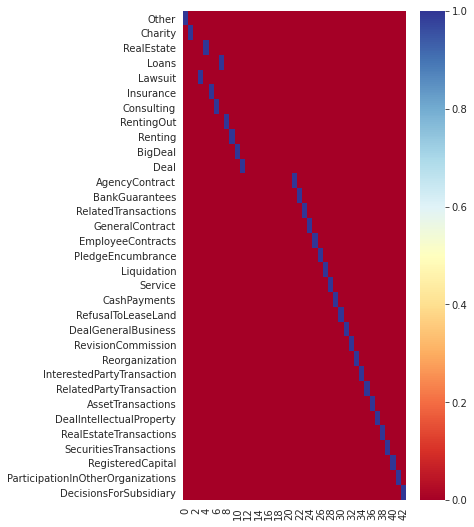

In [8]:
mt = np.array(list( dataset_manager.subject_name_1hot_map.values()))
# for a, b in dataset_manager.subject_name_1hot_map.items():
#   print(a, b)
with sns.axes_style("white"):
  plt.figure(figsize=(5, 9))
  ax = sns.heatmap(mt, square=False,  cmap="RdYlBu")
  ax.set_yticklabels(dataset_manager.subject_name_1hot_map.keys())
  plt.yticks(rotation=0) 
  plt.show()
 
del mt

### Balance trainset 
TODO: consider https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

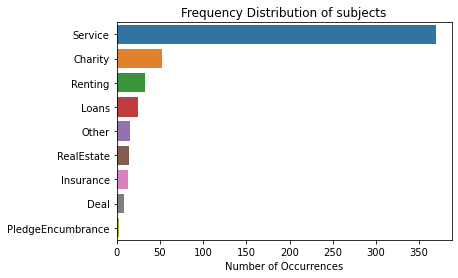


min 3
max 369
total 532
mean length is 992.0112781954887


In [9]:
subj_count = dataset_manager.trainset_rows['subject'].value_counts()


#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

print('mean length is', dataset_manager.trainset_rows['len'].mean())

In [10]:
# REVERSE_TRAIN_AND_TEST_SETS = False
# VALIDATION_SET_PROPORTION = 0.22

print()
print('Number of  test_indices: ', len(dataset_manager.test_indices))
print('Number of train_indices:', len(dataset_manager.train_indices))
print()
print('--Documents included both in train and validation set')
np.intersect1d(dataset_manager.test_indices, dataset_manager.train_indices)


Number of  test_indices:  816
Number of train_indices: 2455

--Documents included both in train and validation set


array([ 13,  61, 173, 238, 246, 507])

## Batch generator & TODOs 🙏

- [x] TODO: ~~try different embedding padding~~ --> not better =(
- [x] TODO: ~~the amount of noise in embedding may depend on popularity of class subject)~~ -->.. hm.. seems like it works
- [x] TODO: try `padded_batch` --> done. 
- [ ] TODO: select min or mean emb length in batch to pad batches
- [ ] TODO: add outliers to the trainset
- [ ] TODO: use sparse_categorical_entropy instead of one-hot encodings

In [0]:
# MAX_SEQUENCE_LENGTH = 800 # mind that mean lenght is 1000
# RANDOMIZE_EMB_PADDING = False

In [12]:
# def _noise_amount( subj ):
#   subj_popularity = subj_count[subj]
#   max_pop = max (subj_count.values)
#   return 1 - subj_popularity/max_pop

## debug ------
print()
for key in subj_count.index:
  print(f'{key}\t {dataset_manager._noise_amount(key)}')


Service	 0.0
Charity	 0.8590785907859079
Renting	 0.9105691056910569
Loans	 0.9322493224932249
Other	 0.959349593495935
RealEstate	 0.962059620596206
Insurance	 0.964769647696477
Deal	 0.978319783197832
PledgeEncumbrance	 0.991869918699187


In [0]:
import numpy as np
EMB_NOISE_AMOUNT = 0.05 #02
  

0.88 Газпром нефть Газпромнефть Шиппинг
0.93 Газпром нефть Газпромнефть-Аэро
0.94 Газпром нефть Газпромнефть-СМ
0.96 Газпромнефть-Аэро Газпромнефть-Энерго
0.97 Газпромнефть-СМ Газпромнефть-ЗС
0.98 Газпромнефть-МНПЗ Газпромнефть-ОНПЗ
HyperParameters.subsidiary_name_match_min_jaro_similarity 0.98


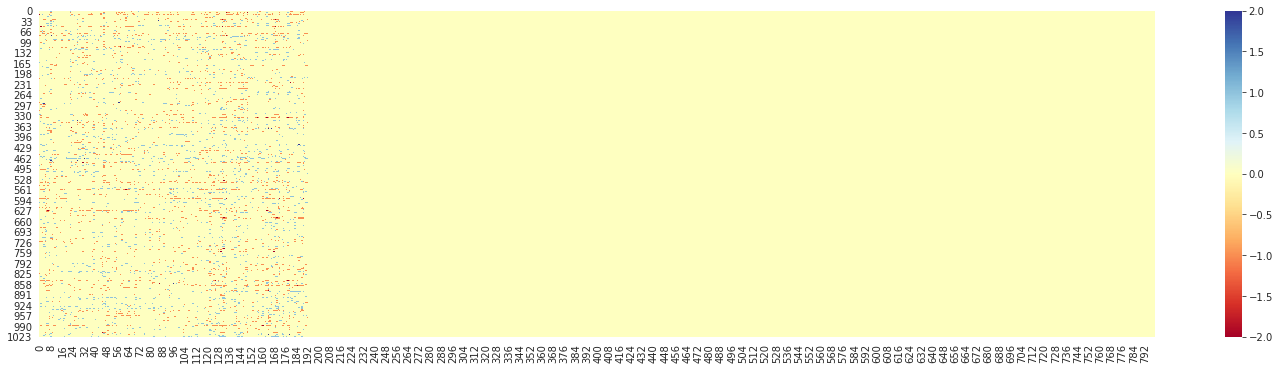

In [14]:
# ---- debug ---
_t_generator = dataset_manager.get_generator(batch_size=1, all_indices=[0], randomize=True)
_t_x, _t_y =  next(_t_generator)
del _t_generator

plot_emb(_t_x[0])

### Visualize embeddings 

In [0]:
## read sample doc pickle
#get sample doc
import pickle
fn_0 = dataset_manager.trainset_rows['pickle'].iloc[1]
with open(fn_0, "rb") as pickle_in:
  doc = pickle.load(pickle_in)


_df = pd.DataFrame()
_df['tokens'] = doc.tokens
# df

#### t-SNE fit

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1400, metric='cosine')
tsne_results = tsne.fit_transform(doc.embeddings)

_df['x']=tsne_results[:,0]
_df['y']=tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 231 samples in 0.001s...
[t-SNE] Computed neighbors for 231 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 231 / 231
[t-SNE] Mean sigma: 0.314537
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.676208
[t-SNE] KL divergence after 1400 iterations: 0.518780


In [0]:
#### K-Means clusterize

In [0]:

from sklearn.cluster import KMeans
X = np.array([_df.x, _df.y]).T
kmeans = KMeans(n_clusters=12)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

_df['y_kmeans'] = y_kmeans


#### filter stop-words out

In [0]:
# filter it
stop_words=['(','ним',')', 'они',',','.',' ','\n','почему', 'мне', 'мы','со','то', 'для','его','твои','ты','если','ок','да','до','бы','а','к','по','про','этим','при','чем','тут','то','так','я','это', '--', '-', 'от', 'и', 'но', 'в', 'на', 'не', 'он', 'она', 'как', 'когда' , 'из', 'с', 'за', '', 'или', 'что', 'же', 'ли', 'нее']

_lines = _df[~_df.tokens.isin(stop_words)]
df = _lines
# for t in df.tokens:
#   print (t)


#### Render it

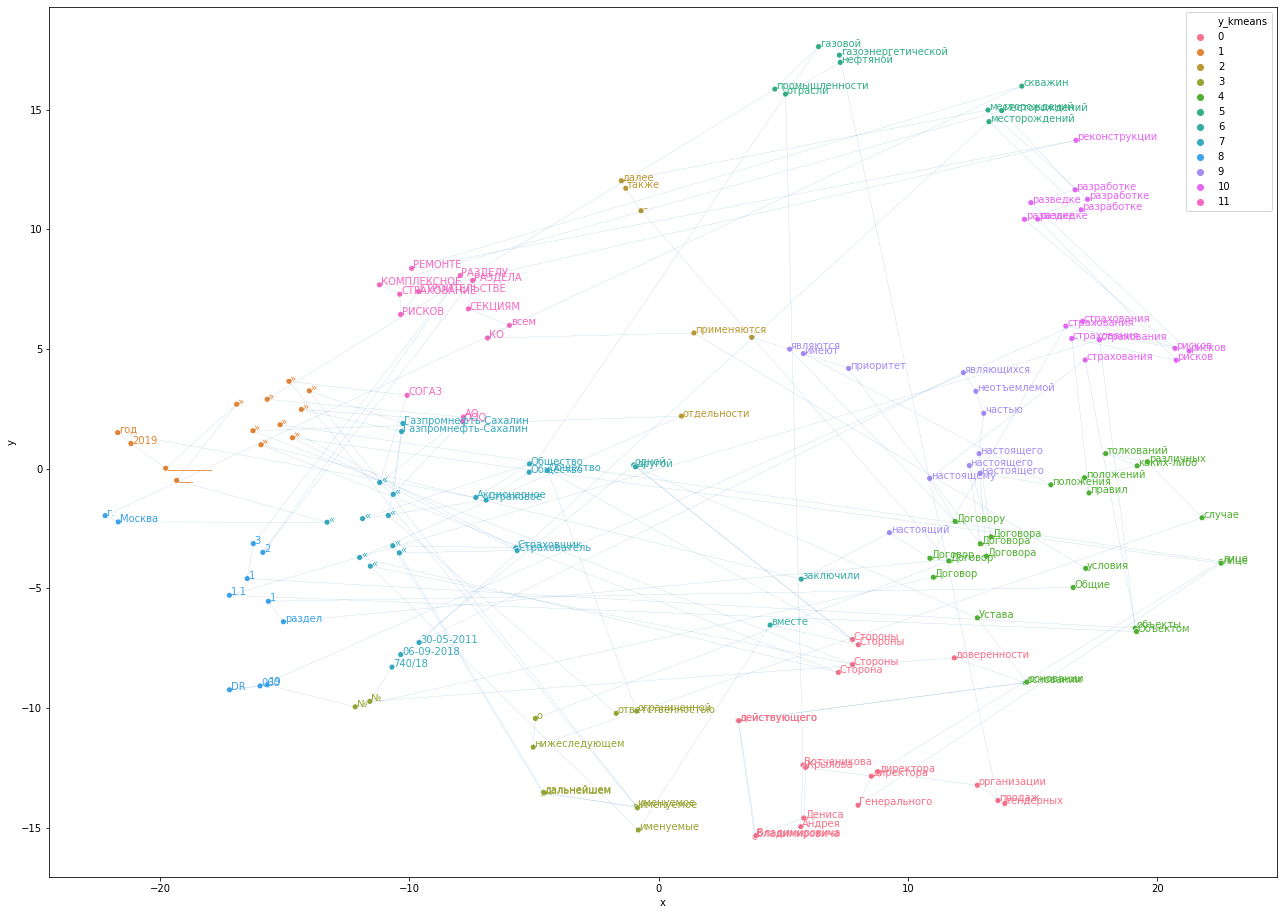

In [20]:
# _palette=['purple','red','orange','blue',  'green', 'black','orange', 'magenta', 'orange', 'green', 'black', 'purple']
_palette = sns.color_palette("husl", 12)
plt.figure(figsize=(22,16))

p1 = sns.scatterplot(df.x, df.y,  legend='full', palette=_palette , hue=df.y_kmeans)

for i, line in df.iterrows():
  p1.text(line.x + 0.05, line.y, line.tokens, 
          horizontalalignment='left', size='medium' , color=_palette[ line.y_kmeans ])
  
p1.plot(df.x, df.y, linewidth=0.2, alpha=0.5)


sample (48, 900, 1024)
sample (48, 43)


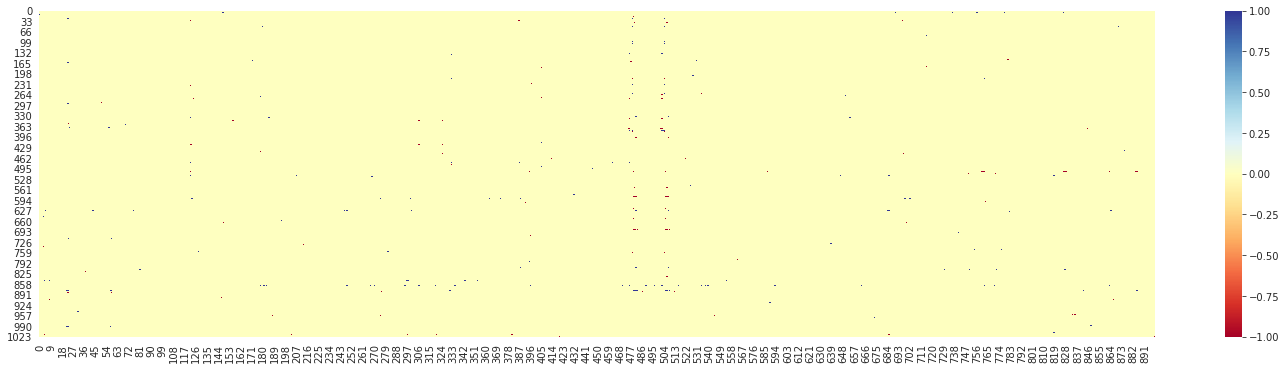

-1
1


In [21]:
EPOCHS=20
BATCH_SIZE=48
EMB=1024 #;//X.shape[-1]

CLASSES=len(list(dataset_manager.subject_name_1hot_map.values())[0])


#create gens

test_generator = dataset_manager.get_generator(batch_size=BATCH_SIZE, all_indices=dataset_manager.test_indices, randomize=True)
next(test_generator)

train_generator = dataset_manager.get_generator(batch_size=BATCH_SIZE, all_indices=dataset_manager.train_indices, randomize=True)
next(train_generator)



#debug ---------------------
_t_x, _t_y =  next(test_generator)
print("sample", _t_x.shape)
print("sample", _t_y.shape)

plot_emb(_t_x[1])
print(_t_x[1].min())
print(_t_x[1].max())

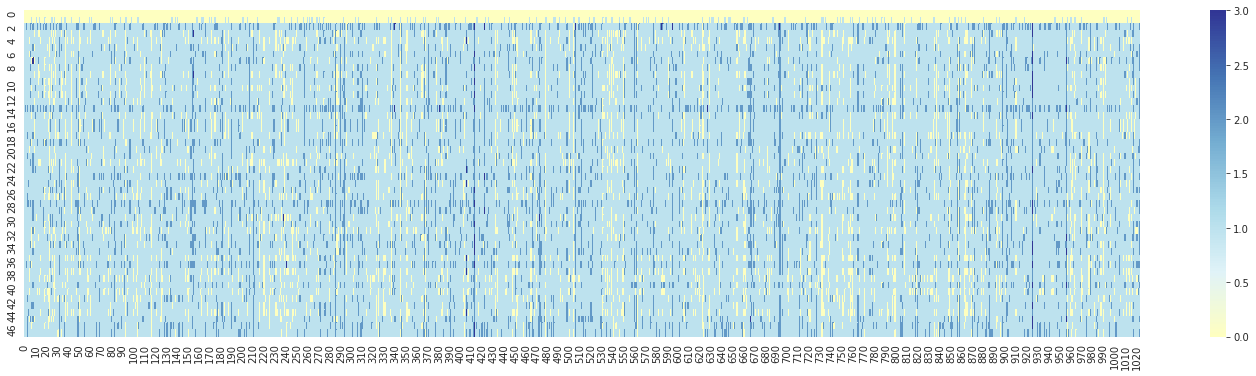

In [22]:
 
plot_emb(_t_x.max(axis=1).T)
# plot_emb(_t_x.mean(axis=1).T)

# Build Models

### common

In [23]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from IPython.display import SVG
from keras.models import load_model


from tensorflow import keras
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout
from keras.models import Sequential, Model
 

1.15.2


In [0]:
HISTORIES={}

In [0]:

def plot_training_history(history):
  # Plot training & validation accuracy values
  for m in history.params['metrics']:
    plt.plot(history.history[m])     
    plt.title(m)
    plt.xlabel('Epoch')
    plt.legend( history.params['metrics'], loc='upper left')
  plt.show()
  

def plot_compare_models():
  plt.figure(figsize=(10,5))
  for key in HISTORIES:
    history = HISTORIES[key]

    # plt.plot(history.history['loss'], label=f'{key} loss')
    plt.plot(history.history['val_loss'], label=f'{key}')
  
  plt.title('Compare models val_loss')   
  plt.legend(loc='upper left')
  plt.show()


def get_stats_df():
  stats_path = path.join(model_checkpoint_path, 'train_statistics0.csv')
  
  try: 
    stats = pd.read_csv(stats_path, index_col='model_name')  
  except: 
    stats = pd.DataFrame(columns = ['epoch','val_acc', 'val_loss', 'loss', 'acc' ])
  
  stats.to_csv(stats_path, index=None, index_label='model_name')
  return stats, stats_path


def save_stats(model_name):
  h = HISTORIES[model_name]
  stats, stats_path = get_stats_df()

  for m in h.params['metrics']:
    stats.at[model_name, m] = h.history[m][-1]
  
  stats.at[model_name, 'epoch'] = h.epoch[-1]
  
  stats.to_csv(stats_path)
  stats.to_csv('stats.csv')
  return stats

# print(HISTORIES['conv_bi_LSTM_dropouts_'].__dict__)
# save_stats('conv_bi_LSTM_dropouts_')

#### Confusion matrix

In [0]:
from analyser.structures import ContractSubject
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

def onehots2labels(preds):
    _x = np.argmax(preds, axis=-1)
    return [ ContractSubject(k).name for k in _x ]

def plot_model_confusion_matrix(model, steps=12, generator=test_generator):
  
  all_predictions= []
  all_originals  = []

  for i in range(steps):
    v_set, v_labels = next(test_generator)

    orig_test_labels = onehots2labels(v_labels)

    _preds = onehots2labels(model.predict (v_set))
    _labels = sorted(np.unique(orig_test_labels + _preds))
    
    all_predictions += _preds
    all_originals +=   orig_test_labels

  
  # Get the confusion matrix
  cm  = confusion_matrix(all_originals, all_predictions, labels=_labels )
  # cm
  plt.figure()
  plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.Blues )
  # plt.yticks(_labels)
  plt.xticks(range(len(_labels)), _labels, fontsize=12, rotation=90)
  plt.yticks(range(len(_labels)), _labels, fontsize=12)
  plt.show()
# cm   




In [27]:

from os import mkdir
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

model_checkpoint_path = path.join(TRAINSETS_PATH, 'checkpoints', VERSION_PATH)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1E-6, verbose=1)

print('model_checkpoint_path', model_checkpoint_path)
 


model_checkpoint_path /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19


In [28]:
validation_steps = int(len(dataset_manager.test_indices)/BATCH_SIZE)
steps_per_epoch = int(len(dataset_manager.train_indices)/BATCH_SIZE/2)

print('validation_steps=', validation_steps)
print('steps_per_epoch=', steps_per_epoch)



def train_and_evaluate_model(model, generator=train_generator, test_generator=test_generator):
  
  print(f'model.name={model.name}')
  dataset_manager.print_parameters()

  _logger1 = CSVLogger( path.join(model_checkpoint_path, model.name+'.log.csv'), separator=',', append=True)
  _logger2 = CSVLogger(  model.name+'.log.csv', separator=',', append=True)


  checkpoint = ModelCheckpoint( path.join(model_checkpoint_path, model.name), 
                               monitor='val_loss', mode='min', save_best_only=True,
                               verbose=1) 
  
  checkpoint_weights = ModelCheckpoint( path.join(model_checkpoint_path, model.name+".weights"), 
                               monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True,
                               verbose=1) 
  
  history = model.fit_generator(
      generator=generator, 
      epochs=EPOCHS,  
      callbacks=[reduce_lr, checkpoint, checkpoint_weights, _logger1, _logger2], 
      steps_per_epoch=steps_per_epoch,
      validation_data=test_generator, 
      validation_steps=validation_steps )
  
  HISTORIES[model.name]=history
  save_stats(model.name)
  plot_training_history(history)
  plot_compare_models()



validation_steps= 17
steps_per_epoch= 25


In [0]:
raise('stop!!')

## Models 🦖

### 0.6458 67K baseline LSTM model

noise on embeddding: 0.02 * K
```
Epoch 10/10
loss: 0.4552 - acc: 0.8409 - val_loss: 0.9700 - val_acc: 0.6514
```

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
loss: 0.4801 - acc: 0.8163 - val_loss: 0.7155 - val_acc: 0.7403
```

```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=baseline_LSTM_model
Epoch 10/10
loss: 0.8650 - acc: 0.6686 - val_loss: 1.0799 - val_acc: 0.6458
```

Model: "baseline_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                66624     
_________________________________________________________________
dense_10 (Dense)             (None, 43)                731       
Total params: 67,355
Trainable params: 67,355
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

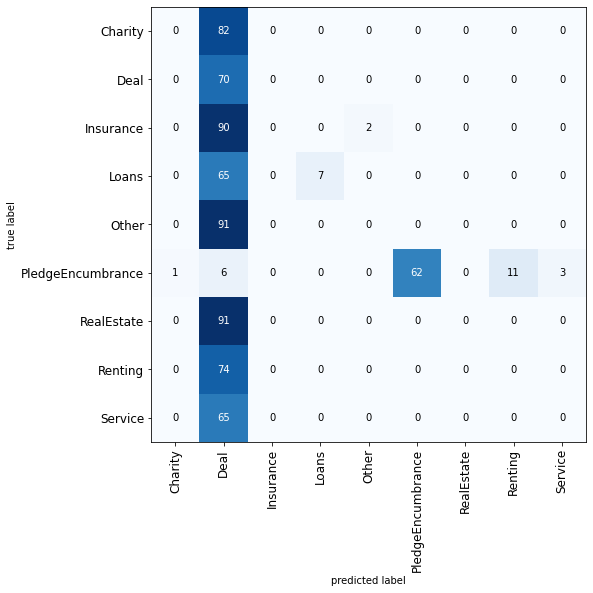

In [60]:

# define baseline model
def baseline_LSTM_model():
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(16, return_sequences=False)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name='baseline_LSTM_model')
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()
  return model



 
model = baseline_LSTM_model(  )
model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))
plot_model_confusion_matrix(model, steps=15)

In [0]:
EPOCHS=3
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=10)
print(e)

### 0.7819 baseline bi-GRU  model (params: 127,163)
overfits?
```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=simple_bi_GRU_model
Epoch 32/32
loss: 0.0332 - acc: 1.0000 - val_loss: 0.8483 - val_acc: 0.7819
```

In [0]:
def simple_bi_GRU_model(name="new_model"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  Bidirectional(GRU(classes*2, return_sequences=False))(input_text)   
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()
  
  return model


 
model = simple_bi_GRU_model( simple_bi_GRU_model.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


In [0]:
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [0]:

EPOCHS=32
train_and_evaluate_model(model)

In [0]:
model.evaluate_generator(generator=test_generator, steps=100)

In [0]:
model.evaluate_generator(generator=train_generator, steps=100)

### 0.7611 👽 bi-LSTMx16 + dropout (0.1)   (params: 134,667)

```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
model.name=simple_bi_LSTM_dropouts
Epoch 20 
loss: 0.0322 - acc: 1.0000 - val_loss: 0.6040 - val_acc: 0.8403
```

```
outliers_percent=0.1
noisy_samples_amount=0.75
noise_amount=0.05
Epoch 22 loss: 0.3242 - acc: 0.9081 - val_loss: 0.6762 - val_acc: 0.7611

```
 

In [0]:
def simple_bi_LSTM_dropouts(name="new_model"):
   
  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.1, name="drops")(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)   
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  
  
  return model

model = simple_bi_LSTM_dropouts( simple_bi_LSTM_dropouts.__name__ )

from keras.models import load_model
model = load_model(path.join(model_checkpoint_path, model.name))
model.summary()

In [0]:
EPOCHS=20
train_and_evaluate_model(model)

In [0]:
# model.evaluate_generator(generator=test_generator, steps=100)

In [0]:
# model.evaluate_generator(generator=train_generator, steps=100)

### 0.5014 simple LSTM model + HUuuge Dropouts (params: 172,163)
```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.02
Epoch 32/32
loss: 0.8510 - acc: 0.6676 - val_loss: 1.3039 - val_acc: 0.5014
```

In [0]:

# define baseline model
def simple_LSTM_model_drops(name="no_name"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes*4, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = simple_LSTM_model_drops( simple_LSTM_model_drops.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))


# print("TEST:--does it work?")
# k=model.predict( X)
# k[0]


In [0]:
EPOCHS=10
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

### 0.7347 10-LSTM (+ recurrent_dropout) [ params: 41,873 ]

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
Epoch 10/10
loss: 0.7828 - acc: 0.8030 - val_loss: 0.9723 - val_acc: 0.7347
```

In [0]:

# define baseline model
def smaller_LSTM_model_drops(name="no_name"):
  classes = min(10, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	 
  bi =  LSTM(classes, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(input_text)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = smaller_LSTM_model_drops( smaller_LSTM_model_drops.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

In [0]:
EPOCHS=10
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=100)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

### 0.7417 👙 16-LSTM + Dropout layer (params: 67,355)

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
Dropout 0.05
loss: 0.5523 - acc: 0.8352 - val_loss: 0.7427 - val_acc: 0.7417
```

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.01
loss: 0.5662 - acc: 0.8324 - val_loss: 0.8604 - val_acc: 0.7111
```

In [0]:

# define baseline model
def small_LSTM_model_dropout_l(name="no_name"):
  classes = min(16, CLASSES) 

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
	
  dr = Dropout(0.05, name="drops")(input_text)
  # bi =  LSTM(classes, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(dr)  
  bi =  LSTM(classes, return_sequences=False, dropout=0.01, recurrent_dropout=0.01)(dr)  
  dense = Dense(CLASSES, activation='softmax')(bi)
  _out = dense
  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = small_LSTM_model_dropout_l( small_LSTM_model_dropout_l.__name__ )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

In [0]:

train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=20)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=100)
print(e)

### 0.6917 Conv + 43-LSTM (params: 61,380)

```
Epoch 10/10
loss: 0.5654 - acc: 0.8011 - val_loss: 0.6737 - val_acc: 0.7903
```

```
filters = 16
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.03
model.name=bigger_LSTM_model_noise_l_n1

Epoch 10/10
loss: 0.4150 - acc: 0.8352 - val_loss: 0.8515 - val_acc: 0.6917
```

In [0]:
from keras.layers import GaussianNoise, GaussianDropout, Conv1D

# define baseline model
def bigger_LSTM_model_noise_l(name="no_name"):
  # classes = min(16, CLASSES)

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
  _layer = input_text

  _layer = Conv1D( filters = 16, kernel_size=(3), padding='same', activation='relu' )(_layer)

 
  # _layer = GaussianNoise(0.1, name="noise")(_layer)  
  
  _layer = LSTM(CLASSES, return_sequences=False, dropout=0.001, recurrent_dropout=0.001)(_layer)  
  _layer = Dense(CLASSES, activation='softmax')(_layer)


  model = Model(inputs=[input_text], outputs=_layer, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='AdaDelta', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = bigger_LSTM_model_noise_l( bigger_LSTM_model_noise_l.__name__+"_n1" )
# SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
 

In [0]:
EPOCHS=10
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=20)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=10)
print(e)

### 0.7667 Conv + 16-LSTM  + Dropout layer (params: 68,395)

```
MAX_SEQUENCE_LENGTH=800
EMB_NOISE_AMOUNT=0.01
model.name=Conv_16x4_LSTM_d5
Epoch 10
loss: 0.5997 - acc: 0.8201 - val_loss: 0.7436 - val_acc: 0.7667
```

 

In [0]:
from keras.layers import GaussianNoise, GaussianDropout, Conv1D


def Conv_16x4_LSTM(name="no_name"):
   
  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")
  _layer = input_text

  _layer = Dropout(0.05, name="drops")(_layer)  
  _layer = Conv1D( filters = 16, kernel_size=(4), padding='same', activation='relu' )(_layer)
  _layer = LSTM(16, return_sequences=False, dropout=0.001, recurrent_dropout=0.001)(_layer)  
  _layer = Dense(CLASSES, activation='softmax')(_layer)


  model = Model(inputs=[input_text], outputs=_layer, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='AdaDelta', metrics=['accuracy'])
  
  model.summary()
  return model


 
model = Conv_16x4_LSTM( Conv_16x4_LSTM.__name__+"_d5" )
 

In [0]:
# EPOCHS=10
train_and_evaluate_model(model)

In [0]:
e=model.evaluate_generator(generator=test_generator, steps=20)
print(e)

In [0]:
e=model.evaluate_generator(generator=all_generator, steps=10)
print(e)

### ❤️ 👽👽 136K ~0.95 + maxPool + bi-LSTMx16 +  dropout (0.1)

```
MAX_SEQUENCE_LENGTH=800
RANDOMIZE_EMB_PADDING=False
EMB_NOISE_AMOUNT=0.05

Epoch 20
loss: 0.0206 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9417

Epoch 40
loss: 0.0185 - acc: 1.0000 - val_loss: 0.1850 - val_acc: 0.9583
```

```
outliers_percent=0.05
noisy_samples_amount=0.5
noise_amount=0.05
Epoch 30
loss: 0.0798 - acc: 0.9782 - val_loss: 0.2614 - val_acc: 0.9306
```
 
```
Epoch 00019: val_loss did not improve from 0.07144
Epoch 20/20
loss: 0.1273 - accuracy: 0.9625 - val_loss: 0.1364 - val_accuracy: 0.9547
```

In [0]:
from keras.layers import MaxPooling1D
def conv_bi_LSTM_dropouts_(name="new_model"):

  dataset_manager.noisy_samples_amount = 0.75
  dataset_manager.outliers_percent = 0.1
  dataset_manager.noise_amount = 0.05
   
  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.1, name="drops")(_out)
  _out = Conv1D( filters = 16, kernel_size=(8), padding='same', activation='relu' )(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)   
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])

  return model

model = conv_bi_LSTM_dropouts_( conv_bi_LSTM_dropouts_.__name__  )
model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))


Model: "conv_bi_LSTM_dropouts_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          131088    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_11 (Dense)             (None, 43)                1419      
Total params: 136,731
Trainable params: 136,731
Non-trainable params: 0
______________________________________

<Figure size 432x288 with 0 Axes>

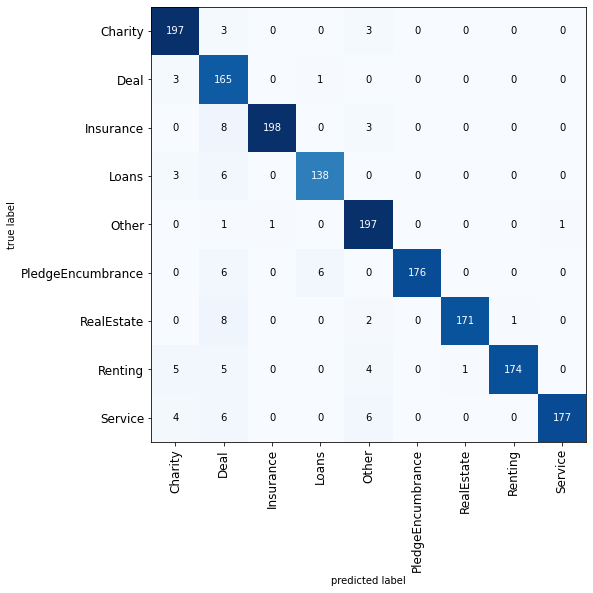

In [62]:
model.summary()
plot_model_confusion_matrix(model, steps=35)

In [0]:
EPOCHS=20
train_and_evaluate_model(model)

In [0]:
# more training
e=model.evaluate_generator(generator=dataset_manager.get_evaluation_generator(BATCH_SIZE), steps=30)
print(e)


### ❤️ 👽136K ~0.95 + maxPool + bi-LSTMx16 +  BINARY


In [0]:
from keras.layers import MaxPooling1D
def conv_bi_LSTM_dropouts_binary(name="new_model"):

  dataset_manager.noisy_samples_amount = 0.75
  dataset_manager.outliers_percent = 0.1
  dataset_manager.noise_amount = 0.05
   
  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.1, name="drops")(_out)
  _out = Conv1D( filters = 16, kernel_size=(8), padding='same', activation='relu' )(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)   
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])

  return model

model = conv_bi_LSTM_dropouts_binary( conv_bi_LSTM_dropouts_binary.__name__  )
model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))


Model: "conv_bi_LSTM_dropouts_binary"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          131088    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_13 (Dense)             (None, 43)                1419      
Total params: 136,731
Trainable params: 136,731
Non-trainable params: 0
________________________________

<Figure size 432x288 with 0 Axes>

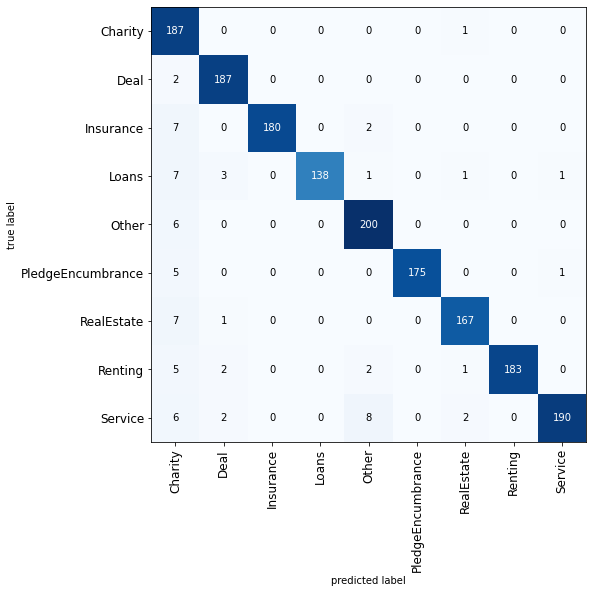

In [67]:
model.summary()
plot_model_confusion_matrix(model, steps=35)

model.name=conv_bi_LSTM_dropouts_binary
outliers_percent=0.1
noisy_samples_amount=0.75
noise_amount=0.05
Epoch 1/20
25/25 [==============================] - 83s 3s/step - loss: 0.0047 - accuracy: 0.9986 - categorical_accuracy: 0.9608 - val_loss: 0.0042 - val_accuracy: 0.9985 - val_categorical_accuracy: 0.9510

Epoch 00001: val_loss improved from inf to 0.00423, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/conv_bi_LSTM_dropouts_binary

Epoch 00001: val_loss improved from inf to 0.00423, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/conv_bi_LSTM_dropouts_binary.weights
Epoch 2/20
25/25 [==============================] - 72s 3s/step - loss: 0.0043 - accuracy: 0.9987 - categorical_accuracy: 0.9617 - val_loss: 0.0059 - val_accuracy: 0.9985 - val_categorical_accuracy: 0.9559

Epoch 00002: val_loss did not improve from 0.00423

Epoch 00002: val_loss did not improve from 0.00423
Epoch 3/20
25/25 [=============================

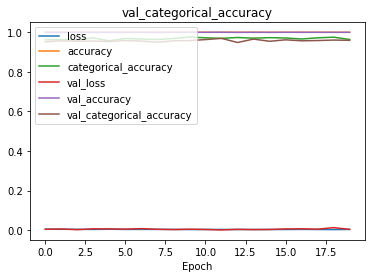

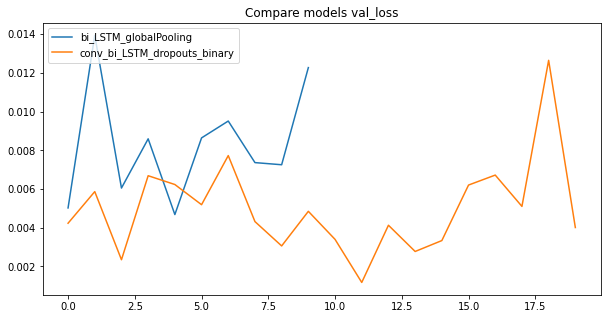

In [66]:
EPOCHS=20
model.load_weights (path.join(model_checkpoint_path, "conv_bi_LSTM_dropouts_"+".weights"))
train_and_evaluate_model(model)

In [0]:
# more training
e=model.evaluate_generator(generator=dataset_manager.get_evaluation_generator(BATCH_SIZE), steps=30)
print(e)


### 👽 0.9510 103K Сonv + maxPool + bi-LSTMx16 +  dropout (0.15)    
#### Model: "conv_bi_LSTM_heavy_dropouts"


```
model.name=conv_bi_LSTM_heavy_dropouts
outliers_percent=0.1
noisy_samples_amount=0.5
noise_amount=0.1
Epoch 32
loss: 0.1221 - acc: 0.9650 - val_loss: 0.2427 - val_acc: 0.9000
```
 

 ```
Trainable params: 103,447
outliers_percent=0.1
noisy_samples_amount=0.75
noise_amount=0.05
loss: 0.1334 - acc: 0.9650 - val_loss: 0.2632 - *val_acc: 0.9083*
 ```

In [0]:
from keras.layers import MaxPooling1D
def conv_bi_LSTM_heavy_dropouts(name:str):
   
  dataset_manager.noisy_samples_amount = 0.75
  dataset_manager.outliers_percent = 0.1
  dataset_manager.noise_amount = 0.05


  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.15, name="drops")(_out)
  _out = Conv1D( filters = 12, kernel_size=(8), padding='same', activation='relu' )(_out)
  _out = MaxPooling1D(pool_size=2)(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False))(_out)   
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

  return model

model = conv_bi_LSTM_heavy_dropouts( conv_bi_LSTM_heavy_dropouts.__name__ )
model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))


Model: "conv_bi_LSTM_heavy_dropouts"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 12)          98316     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 12)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                3712      
_________________________________________________________________
dense_8 (Dense)              (None, 43)                1419      
Total params: 103,447
Trainable params: 103,447
Non-trainable params: 0
_________________________________

<Figure size 432x288 with 0 Axes>

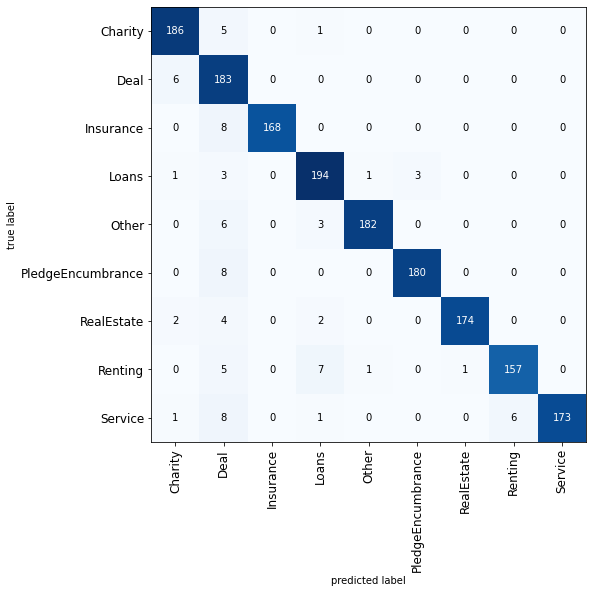

In [58]:
# from keras.models import load_model
# model = load_model(path.join(model_checkpoint_path, conv_bi_LSTM_heavy_dropouts.__name__))
model.summary()
plot_model_confusion_matrix(model, steps=35)

In [0]:

EPOCHS=10
train_and_evaluate_model(model)

In [0]:
# more training
e=model.evaluate_generator(generator=dataset_manager.get_evaluation_generator(BATCH_SIZE), steps=30)
print(e)

### 0.94 210K Global pooling conv + 50% droput + one-way LSTM
@binary_crossentropy

Model: "bi_LSTM_globalPooling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 24)          196632    
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 43)          11696     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 43)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 43)                1892      
Total params: 210,220
Trainable params: 210,220
Non-trainable params: 0
_______________________________________

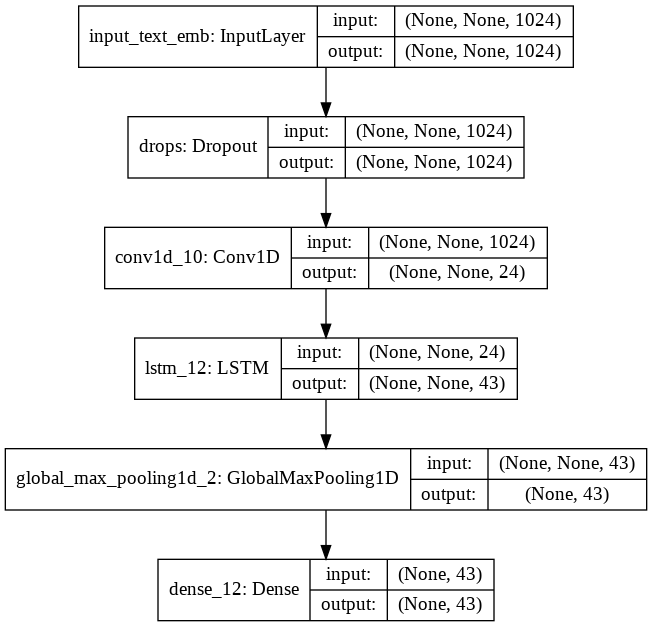

In [63]:
from keras.layers import MaxPooling1D, GlobalMaxPooling1D
 


def bi_LSTM_globalPooling(name:str):
   
  dataset_manager.noisy_samples_amount = 0.75
  dataset_manager.outliers_percent = 0.1
  dataset_manager.noise_amount = 0.05

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.5, name="drops")(_out)
  _out = Conv1D( filters = 24, kernel_size=(8), padding='same', activation='relu' )(_out)
  _out =  LSTM(CLASSES, return_sequences=True)(_out)   
  
  _out = GlobalMaxPooling1D( )(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  # model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=[ 'categorical_accuracy'])

  return model

model = bi_LSTM_globalPooling( bi_LSTM_globalPooling.__name__ )
 
model.summary()
model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))

from keras.utils import plot_model
plot_model(model, show_shapes=True)

<Figure size 432x288 with 0 Axes>

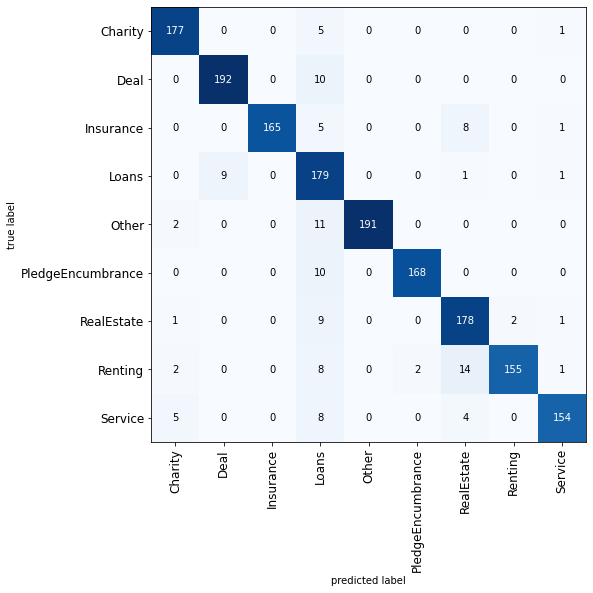

In [64]:
plot_model_confusion_matrix(model, steps=35)

model.name=bi_LSTM_globalPooling
outliers_percent=0.1
noisy_samples_amount=0.75
noise_amount=0.05
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
25/25 [==============================] - 169s 7s/step - loss: 0.0046 - categorical_accuracy: 0.9533 - val_loss: 0.0050 - val_categorical_accuracy: 0.9216

Epoch 00001: val_loss improved from inf to 0.00502, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/bi_LSTM_globalPooling

Epoch 00001: val_loss improved from inf to 0.00502, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/bi_LSTM_globalPooling.weights
Epoch 2/10
25/25 [==============================] - 100s 4s/step - loss: 0.0046 - categorical_accuracy: 0.9533 - val_loss: 0.0139 - val_categorical_accuracy: 0.9154

Epoch 00002: val_loss did not improve from 0.00502

Epoch 00002: val_loss did not improve from 0.00502
Epoch 3/10
25/25 [==============================] - 92s

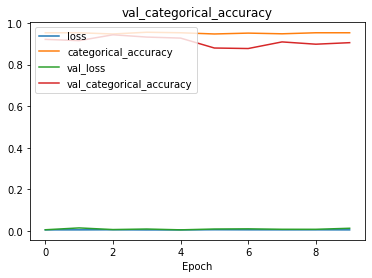

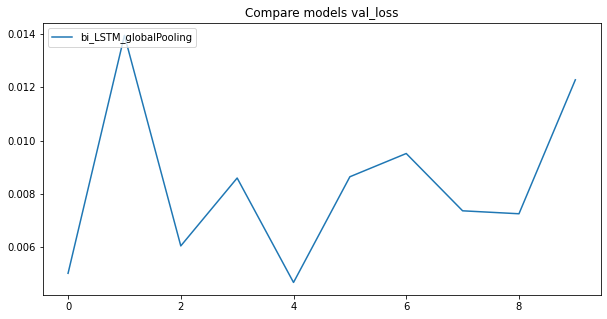

In [31]:
EPOCHS=10
train_and_evaluate_model(model)

### global pooling

In [0]:
from keras.layers import MaxPooling1D, GlobalMaxPooling1D
def conv_conv_globalPooling_2(name:str):
   
  dataset_manager.noisy_samples_amount = 0.75
  dataset_manager.outliers_percent = 0.1
  dataset_manager.noise_amount = 0.05

  input_text = Input(shape=[ None, EMB], dtype='float32', name="input_text_emb")

  _out=input_text
  _out = Dropout(0.1, name="drops")(_out)
  _out = Conv1D( filters = CLASSES, kernel_size=(4), padding='same', activation='relu' , name="conv12x8" )(_out)
  _out = MaxPooling1D(pool_size=2, name="max_pool_x2")(_out)
  _out = Conv1D( filters = CLASSES, kernel_size=(3), padding='same', activation='relu' , name="conv43x3")(_out)
  
  _out = GlobalMaxPooling1D( )(_out)
  _out = Dense(CLASSES, activation='softmax')(_out)
  

  model = Model(inputs=[input_text], outputs=_out, name=name)
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

  return model

model = conv_conv_globalPooling_2( conv_conv_globalPooling_2.__name__ )

In [0]:
from keras.models import load_model
model = load_model(path.join(model_checkpoint_path, 'conv_conv_globalPooling_2'))
model.summary()
EPOCHS=10
e=model.evaluate_generator(generator=dataset_manager.get_evaluation_generator(BATCH_SIZE), steps=50)
print(e)
# train_and_evaluate_model(model)

#Train final model

### conv_bi_LSTM_dropouts_final

```
EMB_NOISE_AMOUNT=0.05
conv_bi_LSTM_dropouts_final

Epoch 40/40
loss: 0.0087 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 1.0000
```

In [68]:
############################################################
BEST_MODEL = conv_bi_LSTM_heavy_dropouts
BEST_MODEL = conv_bi_LSTM_dropouts_binary
############################################################
final_model = BEST_MODEL (  BEST_MODEL.__name__+'_final' )
final_model.load_weights (path.join(model_checkpoint_path, BEST_MODEL.__name__+".weights"))

# final_model = load_model(path.join(model_checkpoint_path, BEST_MODEL.__name__))
# final_model.name = final_model.name+'_final.checkpoint'
final_model.summary()

Model: "conv_bi_LSTM_dropouts_binary_final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text_emb (InputLayer)  (None, None, 1024)        0         
_________________________________________________________________
drops (Dropout)              (None, None, 1024)        0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          131088    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 32)                4224      
_________________________________________________________________
dense_14 (Dense)             (None, 43)                1419      
Total params: 136,731
Trainable params: 136,731
Non-trainable params: 0
__________________________

In [0]:
EPOCHS =40
# generator
all_generator = dataset_manager.get_evaluation_generator(BATCH_SIZE)

#####
train_and_evaluate_model(final_model, generator=all_generator)

<Figure size 432x288 with 0 Axes>

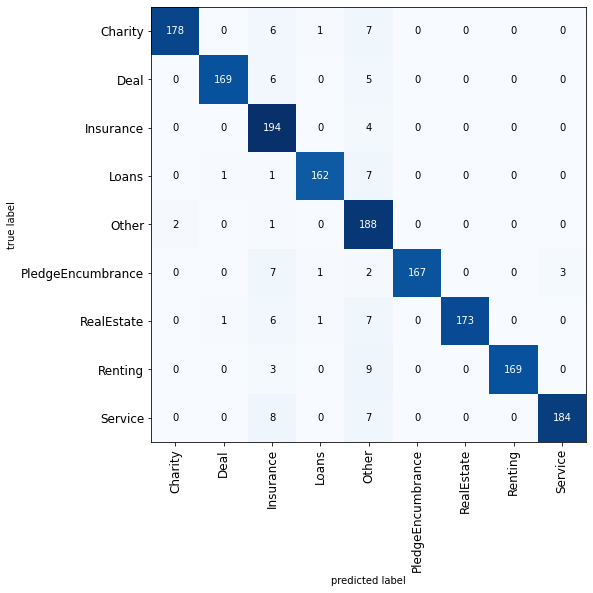

In [73]:
plot_model_confusion_matrix(final_model, steps=35,  generator=all_generator)

# Playground

#### load model

In [0]:
model_name = 'conv_bi_LSTM_heavy_dropouts'#conv_bi_LSTM_dropouts.__name__+""
from keras.models import load_model
model1 = load_model(path.join(model_checkpoint_path, model_name))
model1.summary()

#### Predict all

In [0]:
 
_

In [0]:
# model=final_model
# model1 = load_model(path.join(model_checkpoint_path, 'conv_bi_LSTM_dropouts_'))
model.summary()
from analyser.structures import ContractSubject


# model=final_model
row_no:int=0

prediction_col_name='predicted_subj'

results = dataset_manager._trainset_meta[ dataset_manager._trainset_meta['subject']!='?' ].copy()
results[prediction_col_name]='?'
results[prediction_col_name+"_conf"]=0.0
results[prediction_col_name+"_valid"]=False



for index, row in results.iterrows():
  row_by_no = results.iloc[row_no]

  _subj=row_by_no['subject']
  _filename=row_by_no['pickle']   
  
  _emb = dataset_manager.get_embeddings_raw(_filename)  
  _onehot = dataset_manager.subject_name_1hot_map[ _subj ]


  result = model.predict( np.array( []+ [_emb]) )
  max_i=result[0].argmax()
  predicted_subj_name=ContractSubject(max_i).name

  results[prediction_col_name][index]  = predicted_subj_name
  results[prediction_col_name+"_conf"][index]  = result[0][max_i]
  results[prediction_col_name+"_valid"][index]  = predicted_subj_name==_subj

  print(row_no, index, _subj,'-->', predicted_subj_name, row_by_no['valid'], result[0][max_i] )
  

  if row_no%5==0:
    results.to_csv(path.join(model_checkpoint_path, model.name)+'.csv', encoding='utf-8', index=True)
    results.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

  # if row_no==20:
  #   break 

  row_no+=1

  # if row_no > 21:
  #   break

_actuals = results ['subject']
_predicted = results['predicted_subj']

results.to_csv(  model.name+'.csv', encoding='utf-8', index=True)

In [0]:
_results = results [ results ['subject'] != '?' ] 
_actuals = _results ['subject'].values
_predicted = _results['predicted_subj'].values
_predicted

In [0]:
_labels = sorted(np.unique(np.concatenate( [_actuals, _predicted])))
_labels

In [0]:
# _labels = sorted(np.unique(_actuals + _predicted))
cm  = confusion_matrix(_actuals, _predicted, labels=_labels )
# cm
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.GnBu )
# plt.yticks(_labels)
plt.xticks(range(len(_labels)), _labels, fontsize=11, rotation=90)
plt.yticks(range(len(_labels)), _labels, fontsize=16)
plt.show()